In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score

%matplotlib inline


/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploratory Data Analysis and Building a model for relationship between greenhouse gas emissions from a car and that car's features

We've collected the data, cleaned it up -- now let's build a model!

### Step 1: Prepare dataframe for developing linear regression model
*Edit and add features as needed for desired model*

-

Open the `all_cars_eda` pickled dataframe with all cars data

In [3]:
with open('data/pickles/all_cars_eda.pickle','rb') as read_file:
    all_cars_eda = pickle.load(read_file)

In [9]:
all_cars_eda.columns

Index(['year', 'make', 'model', 'capacity_liters', 'cylinders', 'transmission',
       'trans_speed', 'fuel_type', 'gg_emissions', 'mpg'],
      dtype='object')

-

Create binned categories for `years` based on the year timeframes that the EPA developed national regulations for cars' greenhouse gas emissions:
- 1984 - 2011: 'pre' strict regulations around emissions
- 2012 - 2021: implementation of regulations around emissions.  Note that regulations were 'loosened' by EPA starting with 2021 models, which will be interesting to analyze in coming years, but as of now (July 2020) there are only 36 cars of the 'year' 2021 so data in that category would not yield reliable insights or value.  For now, will remain in regulations bucket since 2021 cars are still under more regulations than prior to 2012

In [4]:
all_cars_eda['year_range'] = ['year_pre_regulations' if
                              year in [1984, 1985, 1986, 
                                       1987, 1988, 1989, 
                                       1990, 1991, 1992, 
                                       1993, 1994, 1995, 
                                       1996, 1997, 1998, 
                                       1999, 2000, 2001,
                                       2002, 2003, 2004,
                                       2005, 2006, 2007,
                                       2008, 2009, 2010,
                                       2011]
                              
                              else 'year_regulations' if 
                              year in [2012,2013,2014,2015,
                                       2016,2017,2018,2019,
                                       2020,2021]           
                              
                              else np.nan for year in all_cars_eda['year']]

Note that we now only have 36 samples in the `year_post_regulations` so will not be enough to draw reliable conclusions from.  But will keep in for now to see any indictation of direction greenhouse gases will take 2021 and beyond >>

In [5]:
all_cars_eda.year_range.value_counts()

year_pre_regulations    3553
year_regulations        1707
Name: year_range, dtype: int64

-

**REMOVING FEATURES**

**Removing miles-per-gallon - `mpg`.**  By removing we'll allow opportunity to examine any relationships between the other features of the car and the greenhouse gas emissions, otherwise miles-per-gallon would be too dominant of feature and also isn't really telling us more deeply what causes greenhouse gas emissions from the mechanics of how the car was built

**Removing `make`, `model`, & `trans_speed`.**  Can say with confidence these are not signiciantly relevant to the greenhouse gas emissions of the car and would not be worth create dummies for the non-numberic categories.

**Removing `year`.**  Will just use the dummy columns created for years.

In [6]:
del all_cars_eda['mpg']
del all_cars_eda['make']
del all_cars_eda['model']
del all_cars_eda['trans_speed']
del all_cars_eda['year']

Verify everything looks okay >>

In [7]:
all_cars_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5264
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   capacity_liters  5260 non-null   float64
 1   cylinders        5260 non-null   int32  
 2   transmission     5260 non-null   object 
 3   fuel_type        5260 non-null   object 
 4   gg_emissions     5260 non-null   float64
 5   year_range       5260 non-null   object 
dtypes: float64(2), int32(1), object(3)
memory usage: 267.1+ KB


-

Create the dummies for the features that are objects and then rename columns with proper formatting to work later in graphing code >>

In [8]:
all_cars_eda = pd.get_dummies(all_cars_eda)

In [9]:
all_cars_eda.columns

Index(['capacity_liters', 'cylinders', 'gg_emissions',
       'transmission_Automatic', 'transmission_Manual', 'fuel_type_Diesel',
       'fuel_type_Premium Gasoline', 'fuel_type_Regular Gasoline',
       'year_range_year_pre_regulations', 'year_range_year_regulations'],
      dtype='object')

In [10]:
all_cars_eda.rename(columns = {'fuel_type_Premium Gasoline': 'fuel_premium',
                               'fuel_type_Regular Gasoline': 'fuel_regular',
                               'fuel_type_Diesel': 'fuel_diesel',
                               'year_range_year_pre_regulations': 'year_pre_regulations',
                               'year_range_year_regulations': 'year_regulations'
                              },
                    inplace = True)

### Step 2: Exploratory Data Analysis

#### CORRELATION

Examine the correlations of all the values>>

In [11]:
all_cars_eda.corr()

,capacity_liters,cylinders,gg_emissions,transmission_Automatic,transmission_Manual,fuel_diesel,fuel_premium,fuel_regular,year_pre_regulations,year_regulations
capacity_liters,1.000000,0.906330,0.773934,0.264746,-0.264746,0.126013,0.135443,-0.199060,0.149540,-0.149540
cylinders,0.906330,1.000000,0.740521,0.309784,-0.309784,0.064916,0.253522,-0.276253,0.105251,-0.105251
gg_emissions,0.773934,0.740521,1.000000,0.169507,-0.169507,-0.010432,0.117899,-0.105576,0.343847,-0.343847
transmission_Automatic,0.264746,0.309784,0.169507,1.000000,-1.000000,-0.058951,0.196403,-0.152445,-0.361508,0.361508
transmission_Manual,-0.264746,-0.309784,-0.169507,-1.000000,1.000000,0.058951,-0.196403,0.152445,0.361508,-0.361508
fuel_diesel,0.126013,0.064916,-0.010432,-0.058951,0.058951,1.000000,-0.198311,-0.376113,0.046135,-0.046135
fuel_premium,0.135443,0.253522,0.117899,0.196403,-0.196403,-0.198311,1.000000,-0.833584,-0.262578,0.262578
fuel_regular,-0.199060,-0.276253,-0.105576,-0.152445,0.152445,-0.376113,-0.833584,1.000000,0.222227,-0.222227
year_pre_regulations,0.149540,0.105251,0.343847,-0.361508,0.361508,0.046135,-0.262578,0.222227,1.000000,-1.000000
year_regulations,-0.149540,-0.105251,-0.343847,0.361508,-0.361508,-0.046135,0.262578,-0.222227,-1.000000,1.000000


-

Now narrow in on just the greenhouse gas emissions column (the 'y') to examine the value of greatest interest more easily >>

In [12]:
(all_cars_eda.corr()).iloc[:,2]

capacity_liters           0.773934
cylinders                 0.740521
gg_emissions              1.000000
transmission_Automatic    0.169507
transmission_Manual      -0.169507
fuel_diesel              -0.010432
fuel_premium              0.117899
fuel_regular             -0.105576
year_pre_regulations      0.343847
year_regulations         -0.343847
Name: gg_emissions, dtype: float64

-

Now create a heatmap to help look at the relationships of the values >>

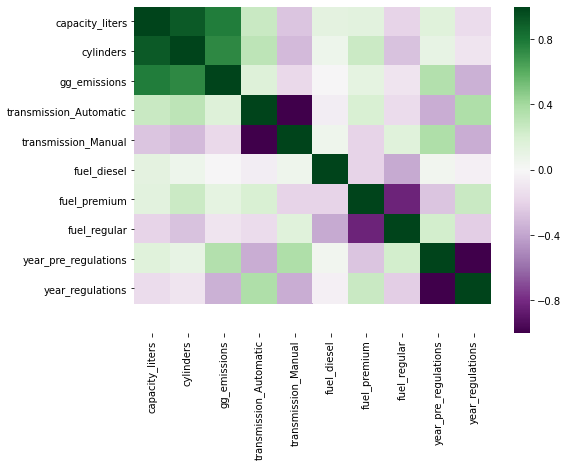

In [13]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(all_cars_eda.corr(), cmap="PRGn")
ax.set_ylim(11.0, 0)

plt.savefig('images/heatmap_correlation_gge.jpg', bbox_inches="tight")
plt.savefig('images/heatmap_correlation_gge.svg', bbox_inches="tight");

And now a Greenhouse Gas Emissions correlation matrix

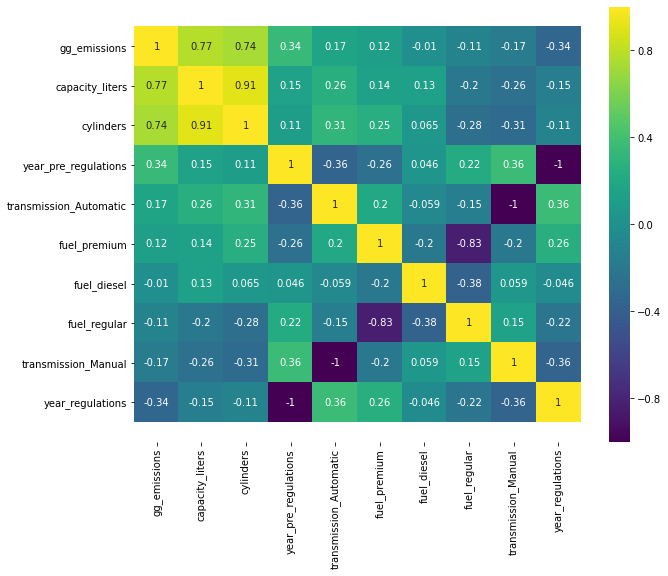

In [14]:
k = 11
cols = all_cars_eda.corr().nlargest(k, 'gg_emissions')['gg_emissions'].index
cm = all_cars_eda[cols].corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, cmap = 'viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('images/correlation_matrix_gge.jpg', bbox_inches="tight")
plt.savefig('images/correlation_matrix_gge.svg', bbox_inches="tight");

### TAKEAWAYS of Correlation Matrix:
- Cylinders highly correlated to capacity liters.  Capacity liters more highly correlated to gge, so will keep capacity liters and remove cylinders from the model
- Transmission & years are fairly high as well, so will need to play with those in the model to see if condition number can be improved

- 

Create a pair plot for a deeper look at relationship between all features and variable >>

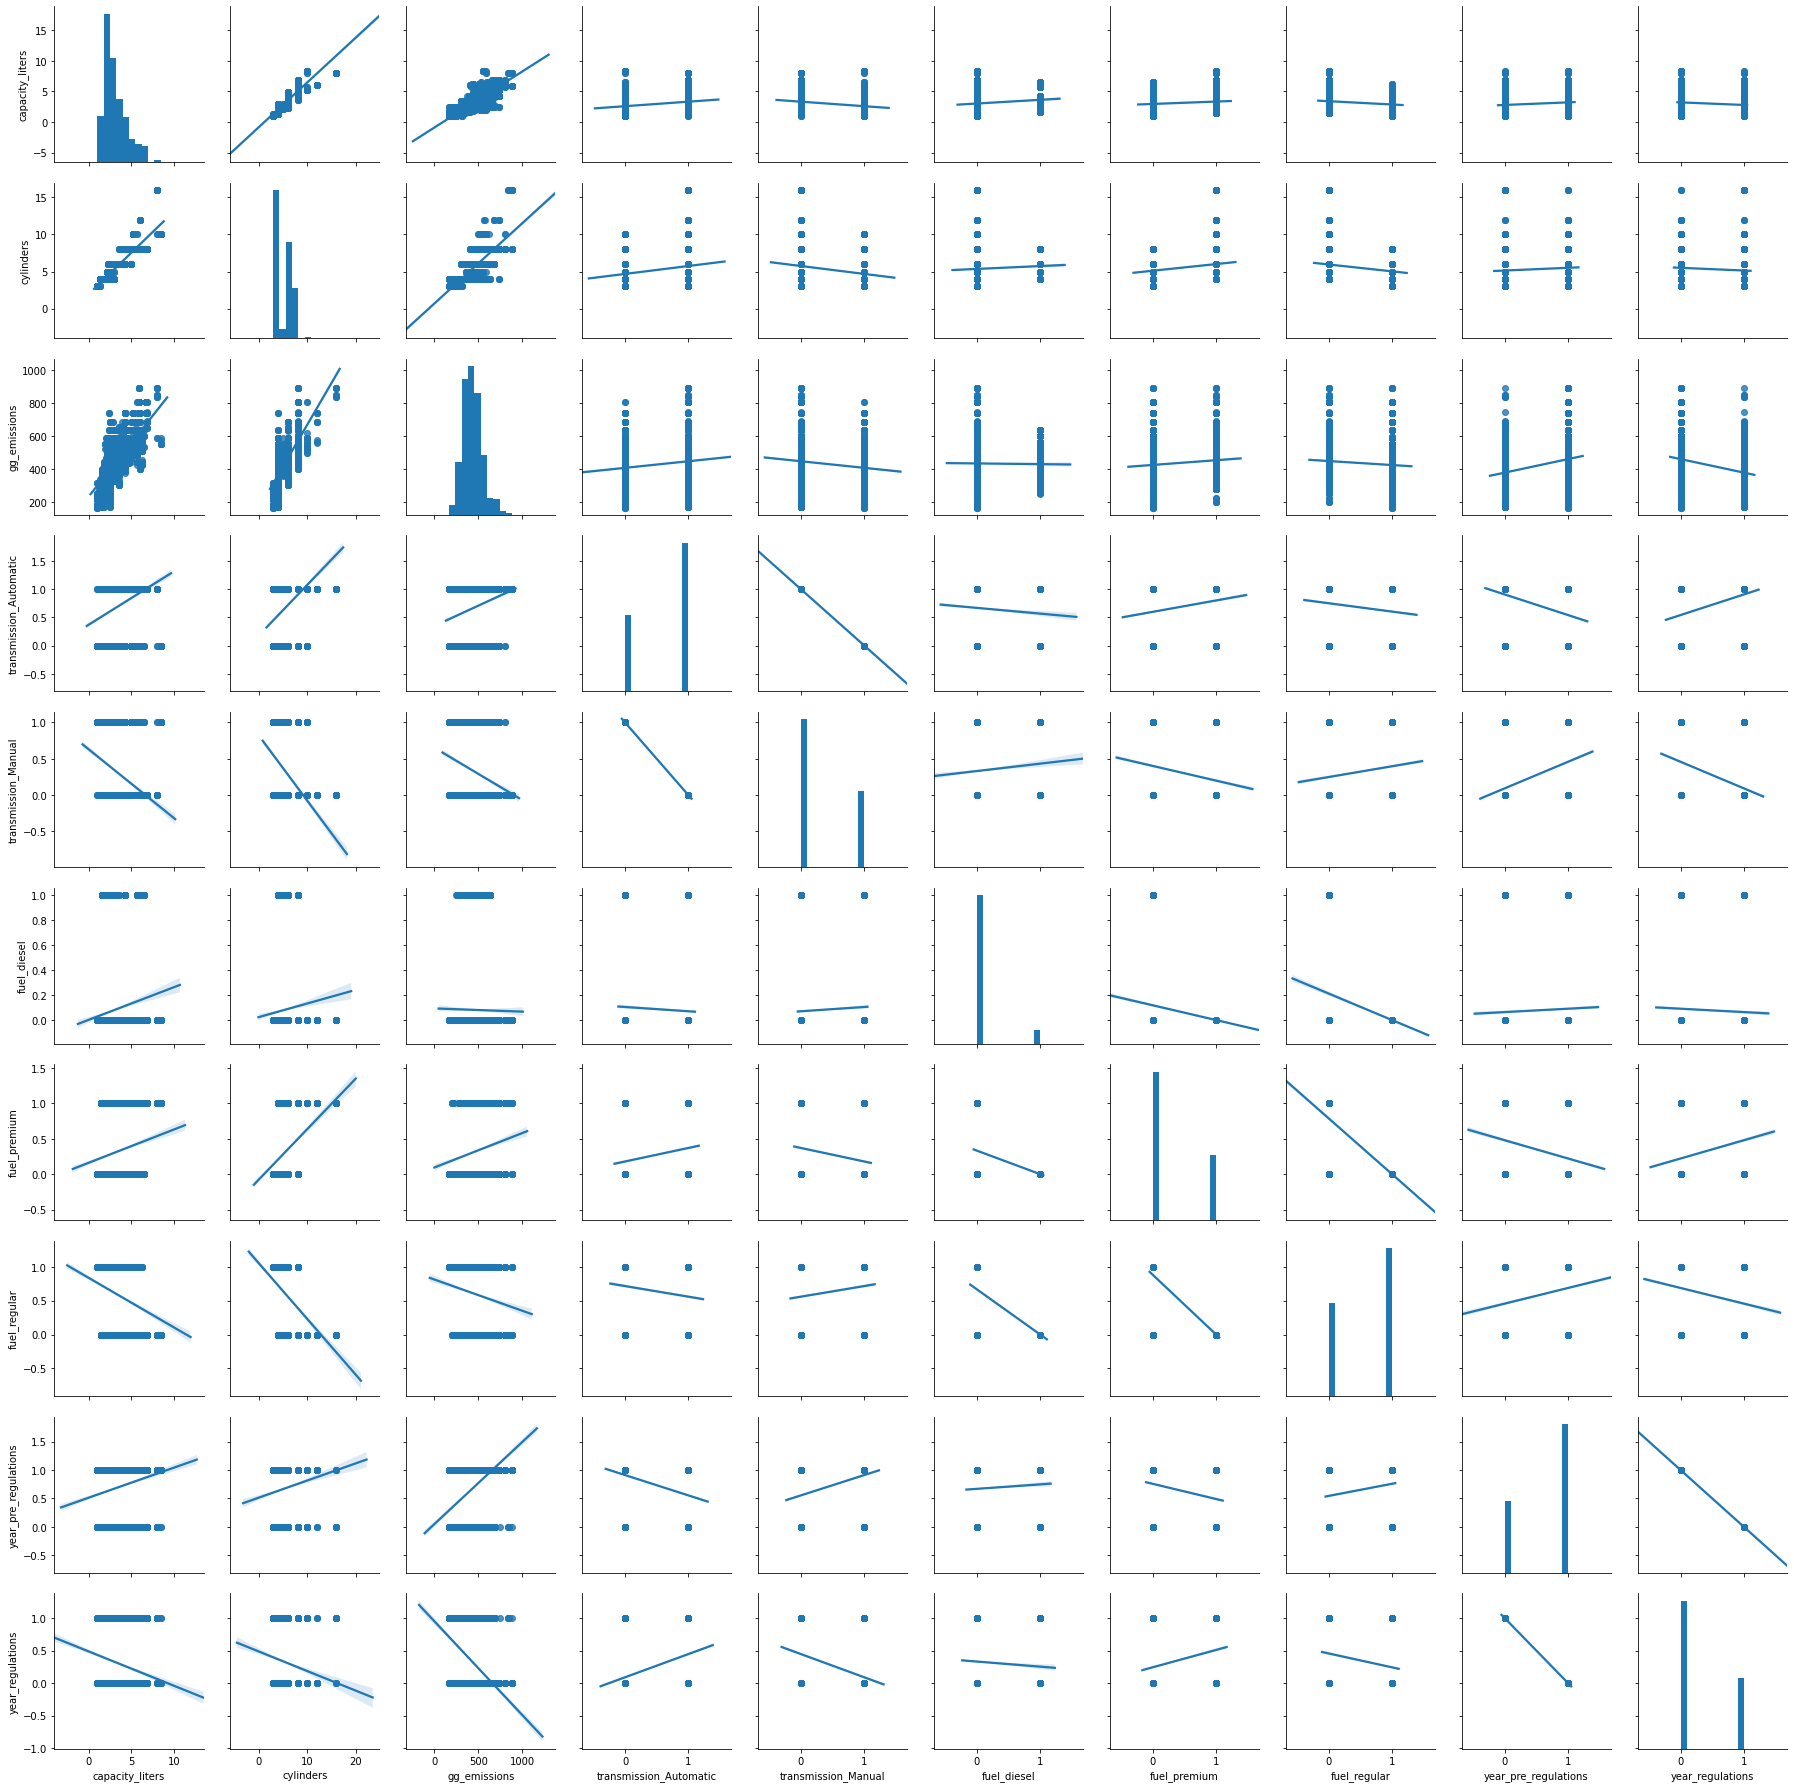

In [15]:
sns.pairplot(all_cars_eda, kind='reg')

plt.savefig('images/pairplot_gge.jpg', bbox_inches="tight")
plt.savefig('images/pairplot_gge.svg', bbox_inches="tight");

#### OUTLIERS EXAMINATION

For our non-dummied features, we'll look at their outliers (dummies can be ignored) >>

TypeError: unsupported operand type(s) for /: 'str' and 'int'

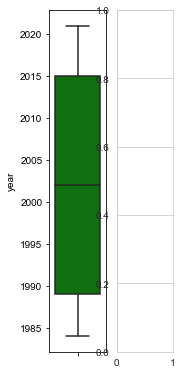

In [4]:
l = all_cars_eda.columns.values
number_of_columns=11
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(all_cars_eda[l[i]],color='green',orient='v')
    plt.tight_layout();

#### CHECK DISTRIBUTION SKEWNESS

Again for our non-dummied features, we'll look at their skewness (dummies can be ignored) >>

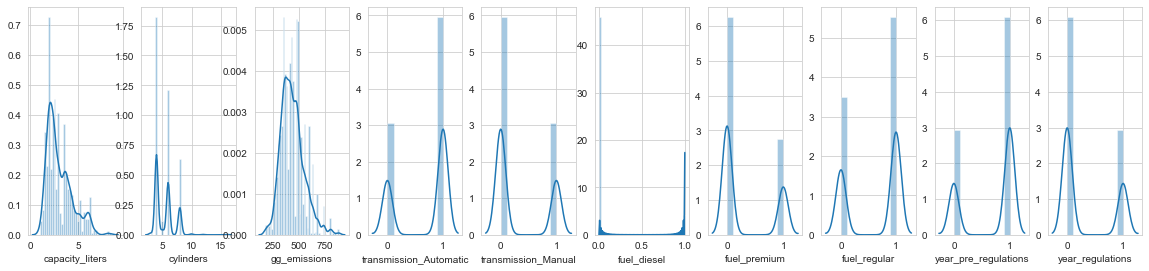

In [17]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(all_cars_eda[l[i]],kde=True)

### STEP 3: BUILD THE MODEL

Reducting to features that critical and not conditional on each other >>

Version #1: Testing model with most features (removed cylinders) >>

In [41]:
# Define the model for greenhouse gas emissions of cars
cars_model_1 = smf.ols('''gg_emissions ~ capacity_liters 
              + transmission_Automatic + fuel_premium + fuel_regular
              + year_regulations''',
                     data=all_cars_eda)

# Fit the model
cars_fit_1 = cars_model_1.fit()

# Print summary statistics of the model's performance
cars_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2152.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:17:44   Log-Likelihood:                -29333.
No. Observations:                5260   AIC:                         5.868e+04
Df Residuals:                    5254   BIC:                         5.872e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                219.3454      4.070     53.893      0.000     211.366     227.324
capacity_liters           60.8326      0.741     82.111      0.000      59.380      62.285
transmission_Automatic    14.6213      2.139      6.834      0.000      10.427      18.815
fuel_premium              54.9184      3.522     15.594      0.000      48.014      61.823
fuel_regular              39.8445      3.333     11.955      0.000      33.311      46.378
year_regulations         -66.6307      2.170    -30.701      0.000     -70.885     -62.376
==============================================================================
Omnibus:                      416.516   Durbin-Watson:                   0.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1137.634
Skew:                           0.440   Prob(JB):                    9.24e-248
Kurtosis:                       5.101   Cond. No.                         23.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Version #2: Testing model with most features (removed cylinders) + removed years >>

In [42]:
# Define the model for greenhouse gas emissions of cars
cars_model_2 = smf.ols('''gg_emissions ~ capacity_liters 
              + transmission_Automatic + fuel_diesel + year_regulations''',
                     data=all_cars_eda)

# Fit the model
cars_fit_2 = cars_model_2.fit()

# Print summary statistics of the model's performance
cars_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2651.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:20:16   Log-Likelihood:                -29360.
No. Observations:                5260   AIC:                         5.873e+04
Df Residuals:                    5255   BIC:                         5.876e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                259.4894      2.450    105.905      0.000     254.686     264.293
capacity_liters           61.8436      0.731     84.565      0.000      60.410      63.277
transmission_Automatic    15.1506      2.149      7.051      0.000      10.938      19.363
fuel_diesel              -45.1041      3.270    -13.795      0.000     -51.514     -38.694
year_regulations         -62.6469      2.111    -29.683      0.000     -66.784     -58.509
==============================================================================
Omnibus:                      387.925   Durbin-Watson:                   0.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1118.763
Skew:                           0.391   Prob(JB):                    1.16e-243
Kurtosis:                       5.120   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# Define the model for greenhouse gas emissions of cars
cars_model = smf.ols('''gg_emissions ~ capacity_liters
              + year_regulations''',
                     data=all_cars_eda)

# Fit the model
cars_fit = cars_model.fit()

# Print summary statistics of the model's performance
cars_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     4929.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:10:52   Log-Likelihood:                -29487.
No. Observations:                5260   AIC:                         5.898e+04
Df Residuals:                    5257   BIC:                         5.900e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          261.5867      2.482    105.409      0.000     256.722     266.452
capacity_liters     62.4728      0.695     89.838      0.000      61.110      63.836
year_regulations   -55.6215      1.961    -28.364      0.000     -59.466     -51.777
==============================================================================
Omnibus:                      367.788   Durbin-Watson:                   0.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              995.009
Skew:                           0.388   Prob(JB):                    8.64e-217
Kurtosis:                       4.984   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-

#### PLOT THE RESIDUALS VS FITTED VALUES

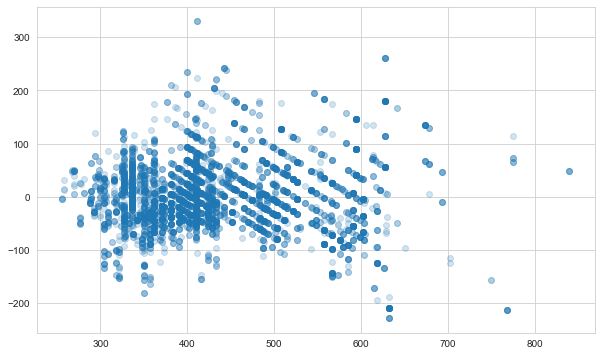

In [42]:
plt.figure(figsize=(10,6))
plt.scatter(cars_fit.predict(), cars_fit.resid, alpha=0.2)

plt.savefig('images/residuals.jpg', bbox_inches="tight")
plt.savefig('images/residuals.svg', bbox_inches="tight");

#### USE SKLEARN TO GET MODEL STATS - SHOULD MATCH ABOVE

*Only used as test to verify different method to get values works*

In [28]:
all_cars_eda.columns

Index(['capacity_liters', 'cylinders', 'gg_emissions',
       'transmission_Automatic', 'transmission_Manual', 'fuel_diesel',
       'fuel_premium', 'fuel_regular', 'year_pre_regulations',
       'year_regulations'],
      dtype='object')

In [134]:
# Create an empty model
cars_lr = LinearRegression()

# Choose the predictor variables
X = all_cars_eda.loc[:, ['capacity_liters', 'cylinders', 'transmission_Automatic', 
                         'transmission_Manual', 'fuel_diesel','fuel_premium',
                         'fuel_regular','year_pre_regulations','year_regulations']]

# Identify the response variable
y = all_cars_eda['gg_emissions']

# Fit the model to the full dataset
cars_lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
print(f'R^2: {cars_lr.score(X,y)}')
print('\n')
print(f'Intercept: {cars_lr.intercept_}')
print('\n')
print(f'Coefficients: {cars_lr.coef_}')

R^2: 0.6777481389965484


Intercept: 198.1048047540253


Coefficients: [ 46.71947403  13.18306272   5.82089064  -5.82089064 -28.72103895
  18.90514405   9.8158949   32.54455902 -32.54455902]


### TEST THE MODEL

Since using smaller sample size, using CV Fold for Cross-validation/test >>

In [135]:
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.70731949, 0.67525752, 0.63702654, 0.61464612, 0.59500336])

In [136]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.69902905, 0.64583361, 0.68964139, 0.65466825, 0.688964  ])

## REGULARIZATION

### Split the data 60 - 20 - 20 train/val/test

In [88]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [89]:
X_train.columns

Index(['capacity_liters', 'cylinders', 'transmission_Automatic',
       'transmission_Manual', 'fuel_diesel', 'fuel_premium', 'fuel_regular',
       'year_pre_regulations', 'year_regulations'],
      dtype='object')

In [90]:
X_test.shape

(1052, 9)

In [91]:
y_test.shape

(1052, 1)

#### Ridge model

In [158]:
lr_model_ridge = Ridge(alpha = 1000000)
lr_model_ridge.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_ridge.coef_))

[('capacity_liters', 0.34647592630396895),
 ('cylinders', 0.40704385765318774),
 ('transmission_Automatic', 0.029306858535819425),
 ('transmission_Manual', -0.029306858535819418),
 ('fuel_diesel', -0.0021173685316568367),
 ('fuel_premium', 0.0196514965422873),
 ('fuel_regular', -0.017534128010630458),
 ('year_pre_regulations', 0.05379815087187283),
 ('year_regulations', -0.05379815087187283)]

#### LASSO model

In [159]:
lr_model_lasso = Lasso(alpha = 1)
lr_model_lasso.fit(X_train_collinear, y_train)

dict(zip(X_train_collinear.columns, lr_model_lasso.coef_))

{'capacity_liters': 45.84878908375614,
 'cylinders': 14.544865930282748,
 'transmission_Automatic': 5.014512781423328,
 'transmission_Manual': -0.0,
 'fuel_diesel': -26.722383642741566,
 'fuel_premium': 4.426838192643665,
 'fuel_regular': 0.0,
 'year_pre_regulations': 56.227078629916655,
 'year_regulations': -0.0}

#### Diagnostics

In [160]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

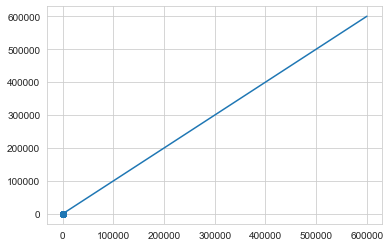

In [161]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))

In [162]:
r2_score(y_test, test_set_pred)

-7.097169534294537

In [163]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

321.8511859218393

#### Scaling

In [164]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [165]:
X_tr = std.transform(X_train.values)

In [166]:
## Apply the scaler to the test set

X_te = std.transform(X_test.values)

In [167]:
## Note that even though we put a Pandas Dataframe into the scalar, what comes out is a numpy array
## In general, sklearn works on numpy.  It will accept pandas objects by trying to coerce them to numpy arrays
## But it will not usually output pandas objects

type(X_train), type(X_tr)

(pandas.core.frame.DataFrame, numpy.ndarray)

(array([2068.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1088.]),
 array([-0.72533591, -0.51493516, -0.30453442, -0.09413367,  0.11626708,
         0.32666783,  0.53706858,  0.74746932,  0.95787007,  1.16827082,
         1.37867157]),
 <a list of 10 Patch objects>)

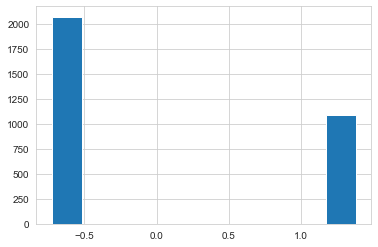

In [168]:
## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

In [169]:
lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_tr,y_train)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [170]:
list(zip(X_train.columns, lasso_model.coef_))

[('capacity_liters', 0.0),
 ('cylinders', 0.0),
 ('transmission_Automatic', 0.0),
 ('transmission_Manual', -0.0),
 ('fuel_diesel', -0.0),
 ('fuel_premium', 0.0),
 ('fuel_regular', -0.0),
 ('year_pre_regulations', 0.0),
 ('year_regulations', -0.0)]

In [171]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))  # just for creating 'empty' plot
err_vec_train = np.zeros(len(alphalist)) # just for creating 'empty' plot

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

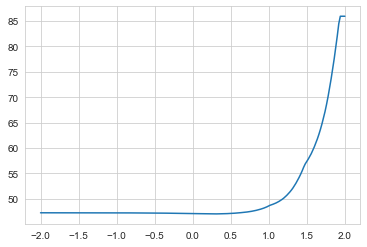

In [172]:
plt.plot(np.log10(alphalist), err_vec_val)

In [173]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

47.01042460482199

In [174]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

1.9563983435170649

In [175]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [176]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [177]:

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [178]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.01

In [179]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('capacity_liters', 62.41457519191097),
 ('cylinders', 19.584354773313187),
 ('transmission_Automatic', 5.772110305365483),
 ('transmission_Manual', -0.0),
 ('fuel_diesel', -10.540392658843363),
 ('fuel_premium', 4.54347666536361),
 ('fuel_regular', -0.0),
 ('year_pre_regulations', 30.45516811917766),
 ('year_regulations', -0.0)]

In [180]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [192]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

46.857254888859224

In [182]:
# find the R^2 score

r2_score(y_test, test_set_pred)

0.699412376143773

In [199]:
# find the intercept
lasso_model.intercept_

433.0551330798479

### BONUS

In [186]:
from sklearn.linear_model import lars_path

In [184]:
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [187]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


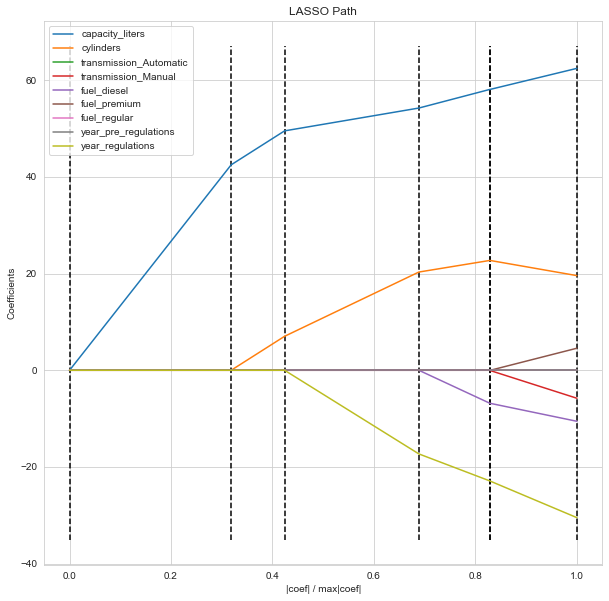

In [190]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)

plt.savefig('images/LASSO_path.jpg', bbox_inches="tight")
plt.savefig('images/LASSO_path.svg', bbox_inches="tight");